In [1]:
SAVE = False

Combine relevant evaluation files into a single file

In [2]:
import sys
sys.path.append('..')
import os
import pandas as pd
import eval_reallabor_utils
import data_utils

MRT = [2, 3]
combined_eval_file = []

for mrt in MRT:

    results_dirs = [
        f'v3_MRT{mrt}_SimpleModels_every_day/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_Kalman_every_day/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_every_day/00_summary_7stepsahead_interv',
        f'v3_MRT{mrt}_Transformer_every_day/00_summary_7stepsahead_interv'
        ]    

    eval_files = []
    for rd in results_dirs:
        eval_files.append(data_utils.join_ordinal_bptt_path('results', rd, 'evaluation.csv'))
        assert os.path.exists(eval_files[-1])
    eval_reallabor_utils.clear_line_and_print(f'Combining evaluation files')
    mrt_combined_eval_file = eval_reallabor_utils.combine_evaluation_files(eval_files, 
                                                                        save_path=None,
                                                                        specifier_name='latent_model')
    mrt_combined_eval_file['MRT'] = mrt

    use_days_from_file = data_utils.train_test_split_path(mrt, 'valid_first_alarms_no_con_smoothed.csv')
    valid_days = pd.read_csv(use_days_from_file, index_col=0)
    valid_days.columns = [int(c) for c in valid_days.columns]

    eval_reallabor_utils.clear_line_and_print(f'Filtering out invalid days')
    eval_only_valid_days = []
    for p, group in mrt_combined_eval_file.groupby('participant'):
        if p in valid_days.columns:
            eval_only_valid_days.append(group.loc[group['test_day'].isin(valid_days[p])])
    mrt_combined_eval_file = pd.concat(eval_only_valid_days, axis=0, ignore_index=True)
    
    mrt_combined_eval_file['prediction'] = mrt_combined_eval_file['prediction'].clip(0, 8)

    combined_eval_file.append(mrt_combined_eval_file)

eval_reallabor_utils.clear_line_and_print(f'Creating grand combined evaluation file')
combined_eval_file = pd.concat(combined_eval_file, axis=0, ignore_index=False)

Creating grand combined evaluation file                                                                                                                                                                 

In [3]:
from eval_reallabor import reallabor_metrics
m_manager = reallabor_metrics.MetricsManager(combined_eval_file, ['MRT', 'latent_model', 'participant', 'feature'], include_r2=False)

Calculate all the metrics and their confidence intervals, separately for models and MRT

In [4]:
metrics, errorbars = {}, {}
metrics['mae'] = m_manager.mae(func='mean')
errorbars['mae'] = m_manager.mae(func='sem')
metrics['diff mae'] = m_manager.diff_mae(func='mean')
errorbars['diff mae'] = m_manager.diff_mae(func='sem')
metrics['interv mae'] = m_manager.interv_mae(func='mean')
errorbars['interv mae'] = m_manager.interv_mae(func='sem')
metrics[r'interv. effect mae'] = m_manager.interv_diff_mae(func='mean')
errorbars[r'interv. effect mae'] = m_manager.interv_diff_mae(func='sem')

How similar are MRT 2 and 3 in terms of item predictability?

In [5]:
from scipy import stats

rank_correlations_of_item_predictability = pd.DataFrame(columns=metrics.keys())
significance_of_rank_correlations = pd.DataFrame(columns=metrics.keys())
for m in metrics.keys():    
    model_grouper = metrics[m].unstack('MRT').groupby(['latent_model', 'feature']).mean().groupby('latent_model')
    rank_correlations_of_item_predictability[m] = model_grouper.apply(lambda x: stats.spearmanr(x[2], x[3]).correlation)
    significance_of_rank_correlations[m] = model_grouper.apply(lambda x: stats.spearmanr(x[2], x[3]).pvalue)
print('Correlations of metrics across samples:')
print(rank_correlations_of_item_predictability)
print('p-values:')
print(significance_of_rank_correlations)

Correlations of metrics across samples:
                            mae  diff mae  interv mae  interv. effect mae
latent_model                                                             
InputsRegression       0.939286  0.810714    0.917857            0.885714
KalmanFilter           0.900000  0.885714    0.842857            0.900000
MeanPredictor          0.932143  0.853571    0.917857            0.814286
MovingAverage(1)       0.889286  0.853571    0.825000            0.814286
Transformer            0.896429  0.857143    0.903571            0.860714
VAR1                   0.896429  0.875000    0.896429            0.907143
clipped-shallow-PLRNN  0.925000  0.864286    0.892857            0.839286
p-values:
                                mae  diff mae  interv mae  interv. effect mae
latent_model                                                                 
InputsRegression       2.094580e-07  0.000246    0.000001            0.000011
KalmanFilter           4.871971e-06  0.000011    0

Plot means of metrics over participants

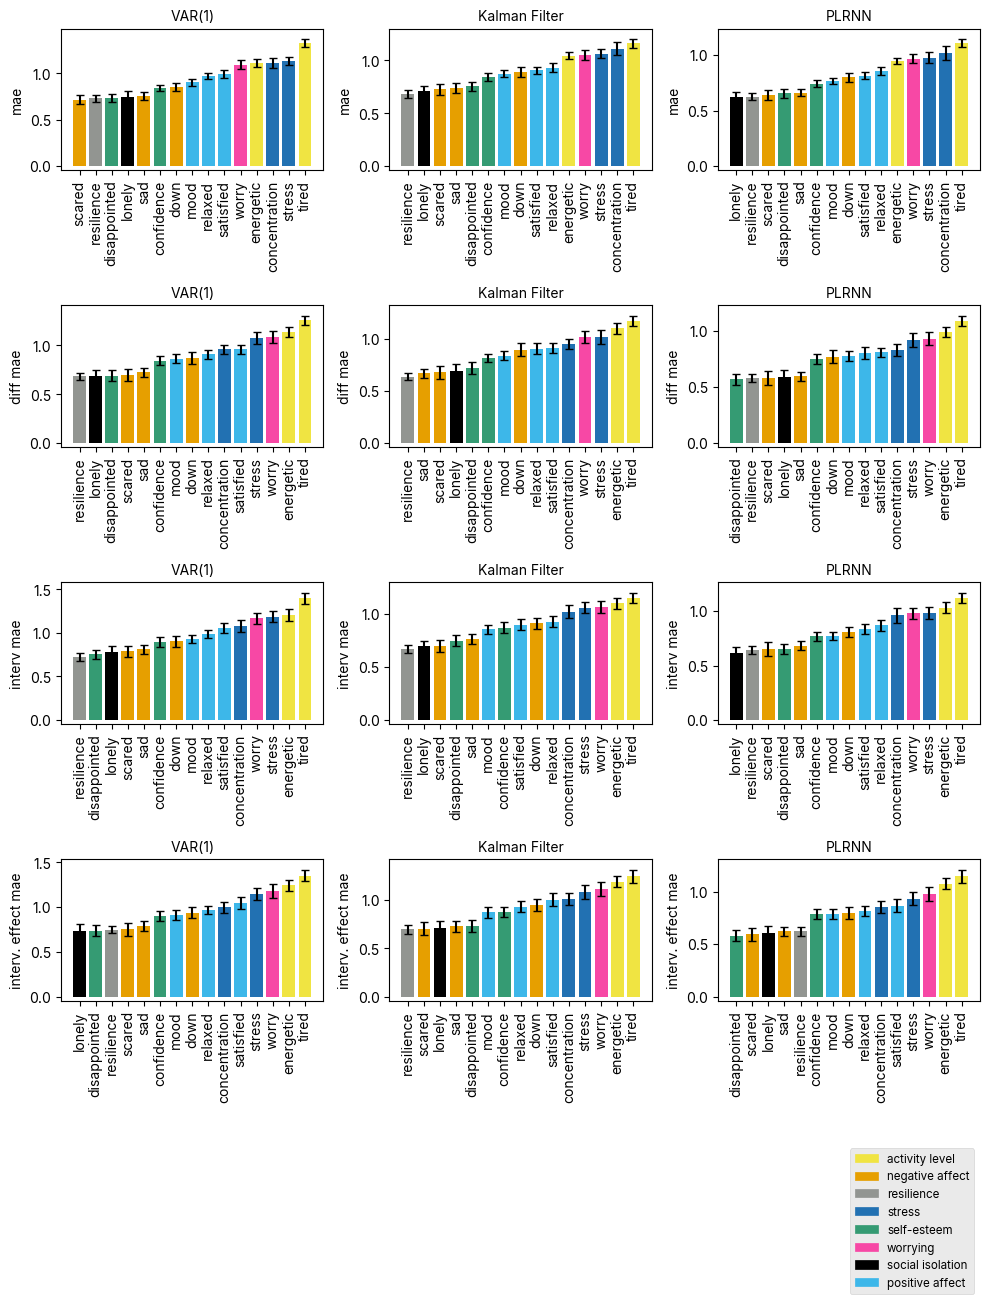

In [22]:
%matplotlib inline

import matplotlib.pyplot as plt
from plotting_styles import PaperStyle, colors
from plotting_utils import adjust_ylim

model_labels = {
                    'VAR1': 'VAR(1)',
                    'KalmanFilter': 'Kalman Filter', 
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    }

features = metrics['mae'].index.get_level_values('feature').unique()

fig, axes = plt.subplots(len(metrics), len(model_labels), figsize=(10, 3*len(metrics)+1), squeeze=False)

with PaperStyle():

    for i, model in enumerate(model_labels.keys()):

        for j, m in enumerate(metrics):
        
            mean_metric = metrics[m].xs(model, level='latent_model').groupby('feature').mean()
            sem_metric = metrics[m].xs(model, level='latent_model').groupby('feature').sem()
            order = mean_metric.sort_values().index
            this_line = mean_metric.loc[order]
            this_errorbars = sem_metric.loc[order]
            axes[j, i].bar(range(len(features)), this_line, yerr=this_errorbars, capsize=3, color=colors.item_color_codes(order))
            adjust_ylim(axes[j, i], 0.03, 0.03)
            
            axes[j, i].set(xticks=range(len(features)))
            axes[j, i].set_xticklabels(order.str.removeprefix('EMA_'), rotation=90)
            axes[j, i].set(title=model_labels[model], ylabel=m)
        plt.tight_layout()
        axes[-1, -1].legend(*colors.construct_legend_handles_labels(*set(colors.item_cosntructs(features))),
                            bbox_to_anchor=(1, -1))
        
    if SAVE:
        plt.savefig(f'../results/_paper/determinants_of_forecasting_quality/individual_items.svg', dpi=300)
    plt.show()

Get item variability and mean (of the complete time series)

In [10]:
mean = pd.read_csv(data_utils.join_base_path('reallaborai4u/descriptive_statistics/_mean.csv'), index_col=[0,1])
std = pd.read_csv(data_utils.join_base_path('reallaborai4u/descriptive_statistics/_std.csv'), index_col=[0,1])

mean = mean.stack()
mean.index.names = ['MRT', 'participant', 'feature']
mean = mean.loc[MRT]
std = std.stack()
std.index.names = ['MRT', 'participant', 'feature']
std = std.loc[MRT]

Calculate correlations between mean and metrics over participants and features

In [11]:
from scipy import stats

model_labels = {
                    'MovingAverage(1)': 'Last Step', 'MeanPredictor': 'Global Mean', 'InputsRegression': 'Linear Regression', 
                    'VAR1': 'VAR(1)', 'KalmanFilter': 'Kalman Filter', 
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    'Transformer': 'Transformer'
                    }

results = []
for model in model_labels.keys():
    model_results = []
    for mrt in MRT:
        mrt_results = []   
        for m in metrics.keys():
            these_metrics = metrics[m].loc[(mrt, model)]
            valid_indices = these_metrics.index[these_metrics.notna()]
            correlation_result = stats.pearsonr(these_metrics.loc[valid_indices], mean.loc[mrt].loc[valid_indices])
            mrt_results.append(f'r={correlation_result.statistic:.3f}, p={correlation_result.pvalue:.3f}')
        mrt_results = pd.Series(mrt_results, index=metrics.keys())
        model_results.append(mrt_results)
    model_results = pd.concat(model_results, keys=MRT)
    results.append(model_results)
results = pd.concat(results, axis=1, keys=model_labels.keys()).T
corr = results.apply(lambda x: x.str.extract(r'r=([-\d.]+), p=([-\d.]+)')[0].astype(float), axis=1)
print('Pearson correlations of metrics with mean for both samples individually:')
results

Pearson correlations of metrics with mean for both samples individually:


2                                      \
                                    mae          diff mae        interv mae   
MovingAverage(1)       r=0.233, p=0.000  r=0.189, p=0.000  r=0.198, p=0.000   
MeanPredictor          r=0.167, p=0.000  r=0.189, p=0.000  r=0.138, p=0.000   
InputsRegression       r=0.181, p=0.000  r=0.178, p=0.000  r=0.167, p=0.000   
VAR1                   r=0.154, p=0.000  r=0.167, p=0.000  r=0.119, p=0.002   
KalmanFilter           r=0.170, p=0.000  r=0.155, p=0.000  r=0.120, p=0.002   
clipped-shallow-PLRNN  r=0.196, p=0.000  r=0.190, p=0.000  r=0.156, p=0.000   
Transformer            r=0.202, p=0.000  r=0.183, p=0.000  r=0.170, p=0.000   

                                                         3                    \
                      interv. effect mae               mae          diff mae   
MovingAverage(1)        r=0.168, p=0.000  r=0.221, p=0.000  r=0.142, p=0.000   
MeanPredictor           r=0.168, p=0.000  r=0.127, p=0.000  r=0.142, p=0.000   
InputsRegression        r=0.161, p=0.000  r=0.141, p=0.000  r=0.145, p=0.000   
VAR1                    r=0.162, p=0.000  r=0.195, p=0.000  r=0.143, p=0.000   
KalmanFilter            r=0.143, p=0.000  r=0.109, p=0.004  r=0.118, p=0.002   
clipped-shallow-PLRNN   r=0.171, p=0.000  r=0.127, p=0.000  r=0.143, p=0.000   
Transformer             r=0.172, p=0.000  r=0.152, p=0.000  r=0.134, p=0.000   

                                                            
                             interv mae interv. effect mae  
MovingAverage(1)       r=0.168, p=0.000   r=0.157, p=0.000  
MeanPredictor          r=0.104, p=0.005   r=0.157, p=0.000  
InputsRegression       r=0.136, p=0.000   r=0.142, p=0.000  
VAR1                   r=0.158, p=0.000   r=0.138, p=0.000  
KalmanFilter           r=0.089, p=0.023   r=0.117, p=0.003  
clipped-shallow-PLRNN  r=0.099, p=0.007   r=0.157, p=0.000  
Transformer            r=0.108, p=0.003   r=0.140, p=0.000

In [13]:
from scipy import stats

model_labels = {
                    'MovingAverage(1)': 'Last Step', 'MeanPredictor': 'Global Mean', 'InputsRegression': 'Linear Regression', 
                    'VAR1': 'VAR(1)', 'KalmanFilter': 'Kalman Filter', 
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    'Transformer': 'Transformer'
                    }

results = []
for model in model_labels.keys():
    model_results = []
    for m in metrics.keys():
        these_metrics = metrics[m].droplevel('MRT').loc[model]
        valid_indices = these_metrics.index[these_metrics.notna()]
        correlation_result = stats.pearsonr(these_metrics.loc[valid_indices], mean.droplevel('MRT').loc[valid_indices])
        model_results.append(f'r={correlation_result.statistic:.3f}, p={correlation_result.pvalue:.3f}')
    model_results = pd.Series(model_results, index=metrics.keys())
    results.append(model_results)
results = pd.concat(results, axis=1, keys=model_labels.keys()).T
corr = results.apply(lambda x: x.str.extract(r'r=([-\d.]+), p=([-\d.]+)')[0].astype(float), axis=1)
print('Pearson correlations of metrics with mean across samples:')
results

Pearson correlations of metrics with mean across samples:


,mae,diff mae,interv mae,interv. effect mae
MovingAverage(1),"r=0.226, p=0.000","r=0.164, p=0.000","r=0.182, p=0.000","r=0.162, p=0.000"
MeanPredictor,"r=0.144, p=0.000","r=0.164, p=0.000","r=0.119, p=0.000","r=0.162, p=0.000"
InputsRegression,"r=0.158, p=0.000","r=0.160, p=0.000","r=0.150, p=0.000","r=0.150, p=0.000"
VAR1,"r=0.174, p=0.000","r=0.154, p=0.000","r=0.138, p=0.000","r=0.148, p=0.000"
KalmanFilter,"r=0.138, p=0.000","r=0.136, p=0.000","r=0.104, p=0.000","r=0.130, p=0.000"
clipped-shallow-PLRNN,"r=0.156, p=0.000","r=0.164, p=0.000","r=0.123, p=0.000","r=0.163, p=0.000"
Transformer,"r=0.174, p=0.000","r=0.156, p=0.000","r=0.135, p=0.000","r=0.156, p=0.000"


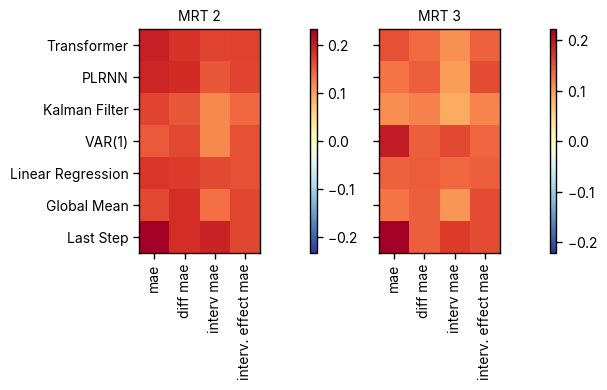

In [104]:
%matplotlib inline

import matplotlib.pyplot as plt
from plotting_styles import PaperStyle, colors
from plotting_utils import heatmap_with_colorbar

with PaperStyle(settings={'axes.grid':False}):

    fig, axes = plt.subplots(1, 2, figsize=(6.27, 4), sharey=True)

    for i, mrt in enumerate(MRT):
        heatmap_with_colorbar(axes[i], corr[mrt].to_numpy(), cmap='RdYlBu_r', symmetrical=True)
        axes[i].set_xticks(range(len(metrics.keys())), labels=metrics.keys(), rotation=90)
        axes[i].set_yticks(range(len(model_labels)), labels=model_labels.values())
        axes[i].set_title(f'MRT {mrt}')

    plt.tight_layout()
    if SAVE:
        plt.savefig('../results/_paper/correlation_of_metrics_with_data_mean.png', dpi=300)
    plt.show()

Calculate correlations between std and metrics over participants and features

In [ ]:
from scipy import stats

model_labels = {
                    'MovingAverage(1)': 'Last Step', 'MeanPredictor': 'Global Mean', 'InputsRegression': 'Linear Regression', 
                    'VAR1': 'VAR(1)', 'KalmanFilter': 'Kalman Filter', 
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    'Transformer': 'Transformer'
                    }

results = []
for model in model_labels.keys():
    model_results = []
    for mrt in MRT:
        mrt_results = []   
        for m in metrics.keys():
            these_metrics = metrics[m].loc[(mrt, model)]
            valid_indices = these_metrics.index[these_metrics.notna()]
            correlation_result = stats.pearsonr(these_metrics.loc[valid_indices], std.loc[mrt].loc[valid_indices])
            mrt_results.append(f'r={correlation_result.statistic:.3f}, p={correlation_result.pvalue:.3f}')
        mrt_results = pd.Series(mrt_results, index=metrics.keys())
        model_results.append(mrt_results)
    model_results = pd.concat(model_results, keys=MRT)
    results.append(model_results)
results = pd.concat(results, axis=1, keys=model_labels.keys()).T
corr = results.apply(lambda x: x.str.extract(r'r=([-\d.]+), p=([-\d.]+)')[0].astype(float), axis=1)
print('Pearson correlations of metrics with std for both samples individually:')
results

Pearson correlations of metrics with std across samples:


2                                      \
                                    mae          diff mae        interv mae   
MovingAverage(1)       r=0.673, p=0.000  r=0.606, p=0.000  r=0.582, p=0.000   
MeanPredictor          r=0.876, p=0.000  r=0.606, p=0.000  r=0.766, p=0.000   
InputsRegression       r=0.868, p=0.000  r=0.664, p=0.000  r=0.693, p=0.000   
VAR1                   r=0.703, p=0.000  r=0.630, p=0.000  r=0.612, p=0.000   
KalmanFilter           r=0.789, p=0.000  r=0.649, p=0.000  r=0.676, p=0.000   
clipped-shallow-PLRNN  r=0.849, p=0.000  r=0.621, p=0.000  r=0.736, p=0.000   
Transformer            r=0.818, p=0.000  r=0.620, p=0.000  r=0.709, p=0.000   

                                                         3                    \
                      interv. effect mae               mae          diff mae   
MovingAverage(1)        r=0.537, p=0.000  r=0.655, p=0.000  r=0.545, p=0.000   
MeanPredictor           r=0.537, p=0.000  r=0.805, p=0.000  r=0.545, p=0.000   
InputsRegression        r=0.615, p=0.000  r=0.808, p=0.000  r=0.589, p=0.000   
VAR1                    r=0.574, p=0.000  r=0.759, p=0.000  r=0.581, p=0.000   
KalmanFilter            r=0.573, p=0.000  r=0.701, p=0.000  r=0.554, p=0.000   
clipped-shallow-PLRNN   r=0.554, p=0.000  r=0.787, p=0.000  r=0.554, p=0.000   
Transformer             r=0.549, p=0.000  r=0.806, p=0.000  r=0.555, p=0.000   

                                                            
                             interv mae interv. effect mae  
MovingAverage(1)       r=0.548, p=0.000   r=0.515, p=0.000  
MeanPredictor          r=0.723, p=0.000   r=0.515, p=0.000  
InputsRegression       r=0.693, p=0.000   r=0.547, p=0.000  
VAR1                   r=0.614, p=0.000   r=0.527, p=0.000  
KalmanFilter           r=0.661, p=0.000   r=0.515, p=0.000  
clipped-shallow-PLRNN  r=0.697, p=0.000   r=0.524, p=0.000  
Transformer            r=0.698, p=0.000   r=0.524, p=0.000

In [14]:
from scipy import stats

model_labels = {
                    'MovingAverage(1)': 'Last Step', 'MeanPredictor': 'Global Mean', 'InputsRegression': 'Linear Regression', 
                    'VAR1': 'VAR(1)', 'KalmanFilter': 'Kalman Filter', 
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    'Transformer': 'Transformer'
                    }

results = []
for model in model_labels.keys():
    model_results = []
    for m in metrics.keys():
        these_metrics = metrics[m].droplevel('MRT').loc[model]
        valid_indices = these_metrics.index[these_metrics.notna()]
        correlation_result = stats.pearsonr(these_metrics.loc[valid_indices], std.droplevel('MRT').loc[valid_indices])
        model_results.append(f'r={correlation_result.statistic:.3f}, p={correlation_result.pvalue:.3f}')
    model_results = pd.Series(model_results, index=metrics.keys())
    results.append(model_results)
results = pd.concat(results, axis=1, keys=model_labels.keys()).T
corr = results.apply(lambda x: x.str.extract(r'r=([-\d.]+), p=([-\d.]+)')[0].astype(float), axis=1)
print('Pearson correlations of metrics with std across samples:')
results

Pearson correlations of metrics with std across samples:


,mae,diff mae,interv mae,interv. effect mae
MovingAverage(1),"r=0.661, p=0.000","r=0.570, p=0.000","r=0.562, p=0.000","r=0.523, p=0.000"
MeanPredictor,"r=0.838, p=0.000","r=0.570, p=0.000","r=0.740, p=0.000","r=0.523, p=0.000"
InputsRegression,"r=0.837, p=0.000","r=0.627, p=0.000","r=0.692, p=0.000","r=0.584, p=0.000"
VAR1,"r=0.733, p=0.000","r=0.606, p=0.000","r=0.616, p=0.000","r=0.553, p=0.000"
KalmanFilter,"r=0.744, p=0.000","r=0.594, p=0.000","r=0.667, p=0.000","r=0.541, p=0.000"
clipped-shallow-PLRNN,"r=0.812, p=0.000","r=0.582, p=0.000","r=0.710, p=0.000","r=0.538, p=0.000"
Transformer,"r=0.811, p=0.000","r=0.582, p=0.000","r=0.697, p=0.000","r=0.535, p=0.000"


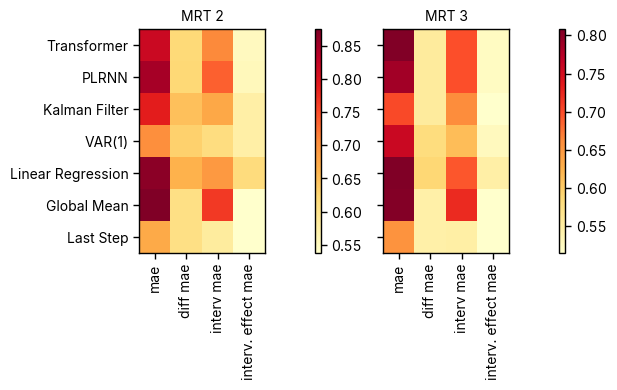

In [107]:
%matplotlib inline

import matplotlib.pyplot as plt
from plotting_styles import PaperStyle, colors
from plotting_utils import heatmap_with_colorbar

with PaperStyle(settings={'axes.grid':False}):

    fig, axes = plt.subplots(1, 2, figsize=(6.27, 4), sharey=True)

    for i, mrt in enumerate(MRT):
        heatmap_with_colorbar(axes[i], corr[mrt].to_numpy(), cmap='YlOrRd', symmetrical=False)
        axes[i].set_xticks(range(len(metrics.keys())), labels=metrics.keys(), rotation=90)
        axes[i].set_yticks(range(len(model_labels)), labels=model_labels.values())
        axes[i].set_title(f'MRT {mrt}')

    plt.tight_layout()
    if SAVE:
        plt.savefig('../results/_paper/correlation_of_metrics_with_data_std.png', dpi=300)
    plt.show()

Plot all item mean and std against MAE in scatter plots, calculate their individual correlation (over participants) with MAE, for single MRT and single latent model

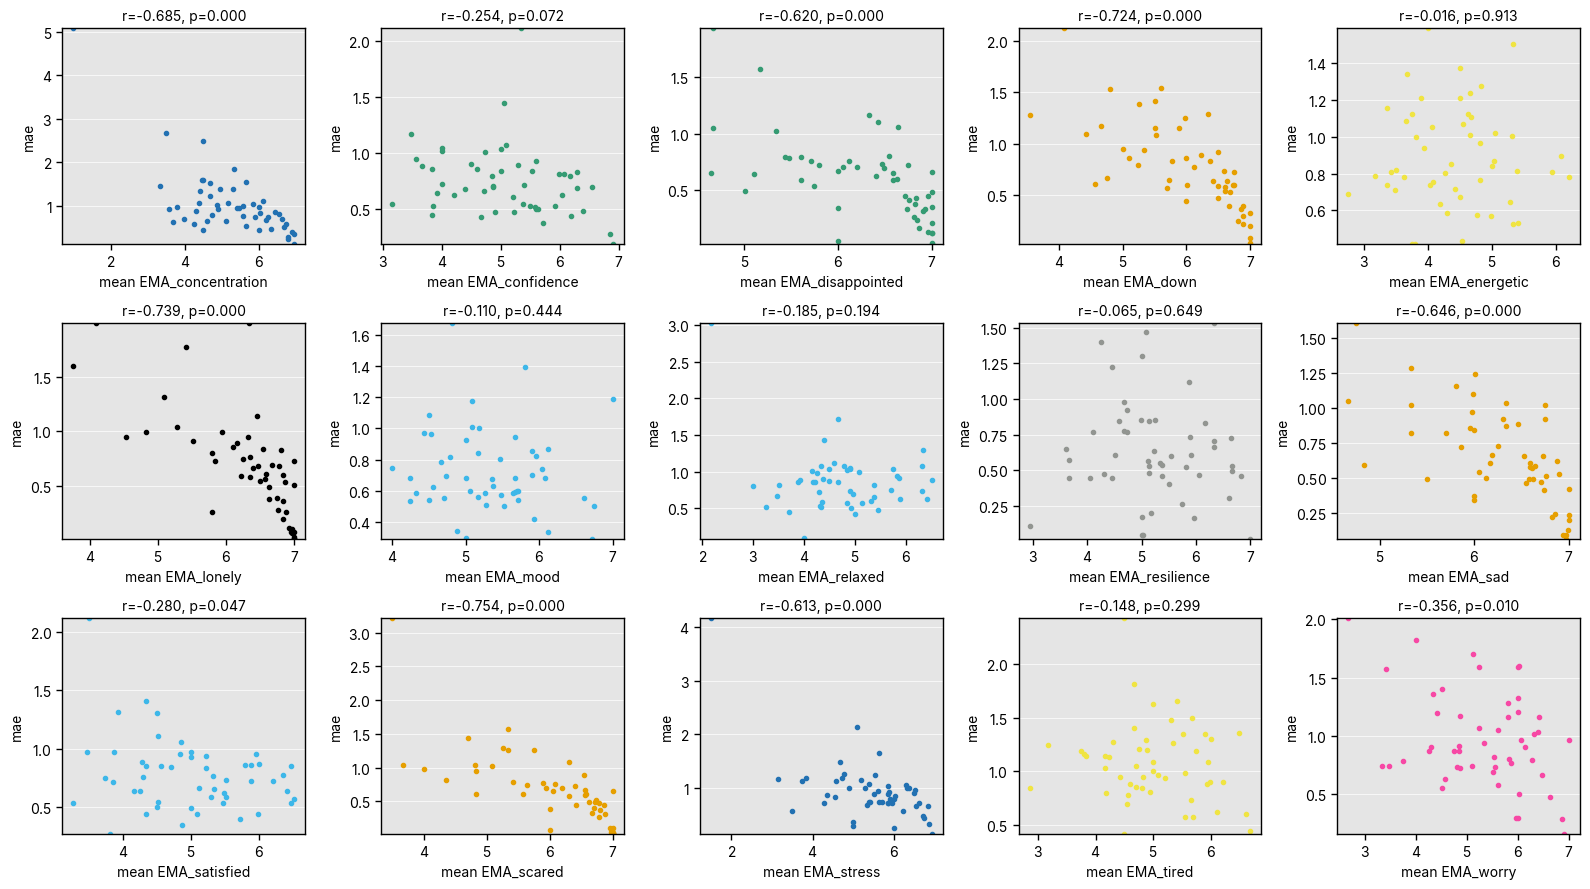

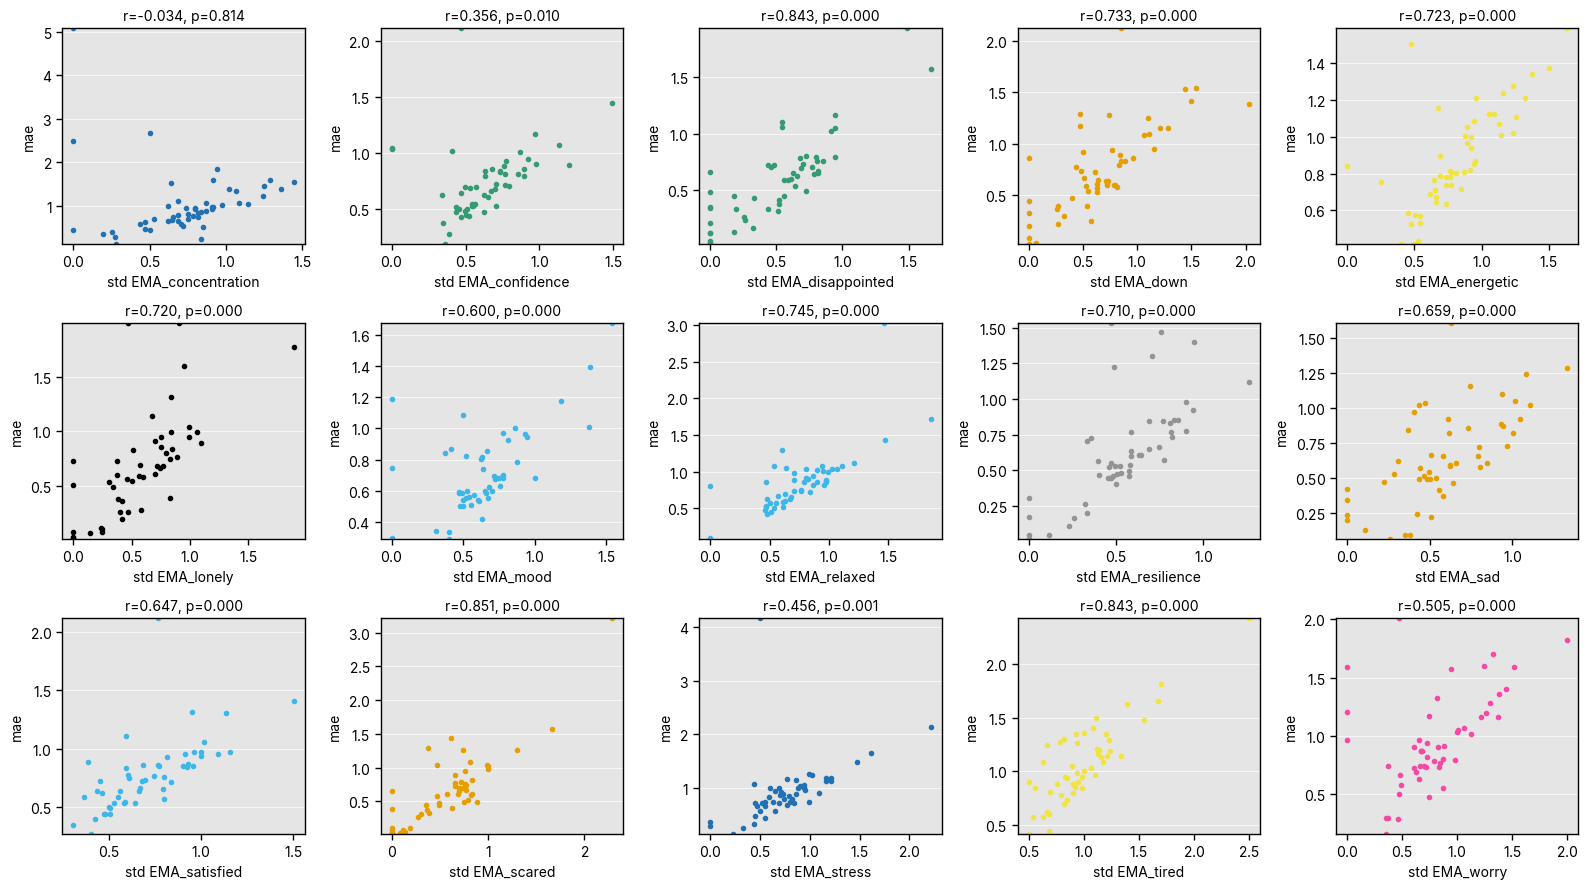

In [71]:
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
from plotting_styles import PaperStyle, colors

mrt = 3
model = 'clipped-shallow-PLRNN'

item_means_and_var = combined_eval_file.loc[combined_eval_file['latent_model']==model].groupby(['MRT', 'latent_model', 'participant', 'feature'])[['gt_mean', 'gt_var']].mean()
item_names = metrics['mae'].index.get_level_values('feature').unique()

with PaperStyle():
    fig, axes = plt.subplots(3, 5, figsize=[16,9])
    axes = axes.flatten()
    idx = pd.IndexSlice

    for j, item in enumerate(item_names):
        try:
            corr = pearsonr(item_means_and_var.loc[idx[mrt, model, :, item], 'gt_mean'].dropna(), metrics['mae'].loc[idx[mrt, model, :, item]].dropna())
        except Exception as e:
            print(e)
        else:
            r = (corr.statistic)
            p = (corr.pvalue)
            axes[j].plot(item_means_and_var.loc[idx[mrt, model, :, item], 'gt_mean'].dropna(), metrics['mae'].loc[idx[mrt, model, :, item]].dropna(), marker='.', linestyle='', color=colors.item_color_codes([item])[0])
            axes[j].set(ylabel='mae', xlabel=f'mean {item}', title=f'r={r:.3f}, p={p:.3f}')

    plt.tight_layout()

with PaperStyle():
    fig, axes = plt.subplots(3, 5, figsize=[16,9])
    axes = axes.flatten()
    idx = pd.IndexSlice

    for j, item in enumerate(item_names):
        try:
            corr = pearsonr(np.sqrt(item_means_and_var.loc[idx[mrt, model, :, item], 'gt_var'].dropna()), metrics['mae'].loc[idx[mrt, model, :, item]].dropna())
        except Exception as e:
            print(e)
        else:
            r = (corr.statistic)
            p = (corr.pvalue)
            axes[j].plot(np.sqrt(item_means_and_var.loc[idx[mrt, model, :, item], 'gt_var'].dropna()), metrics['mae'].loc[idx[mrt, model, :, item]].dropna(), marker='.', linestyle='', color=colors.item_color_codes([item])[0])
            axes[j].set(ylabel='mae', xlabel=f'std {item}', title=f'r={r:.3f}, p={p:.3f}')

    plt.tight_layout()

    plt.show()

Stationary and Metrics

In [15]:
stationarity = pd.read_csv(data_utils.join_base_path('reallaborai4u/descriptive_statistics/_stationarity.csv'), index_col=[0,1]).astype(bool)

stationarity = stationarity.stack()
stationarity.index.names = ['MRT', 'participant', 'feature']
stationarity = stationarity.loc[MRT]

In [ ]:
from scipy.stats import ttest_ind, mannwhitneyu
from collections import defaultdict

test = mannwhitneyu
model_labels = {
                    'MovingAverage(1)': 'Last Step', 'MeanPredictor': 'Global Mean', 'InputsRegression': 'Linear Regression', 
                    'VAR1': 'VAR(1)', 'KalmanFilter': 'Kalman Filter', 
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    'Transformer': 'Transformer'
                    }

results = []
for model in model_labels.keys():
    model_results = []
    for mrt in MRT:
        mrt_results = []
        for m in metrics.keys():
            these_metrics = metrics[m].loc[(mrt, model)]
            valid_indices = these_metrics.index[these_metrics.notna()]
            ttest_result = test(these_metrics.loc[stationarity.loc[mrt].loc[these_metrics.index]], 
                                     these_metrics.loc[~stationarity.loc[mrt].loc[these_metrics.index]], 
                                     axis=0, nan_policy='omit', alternative='less')
            if test == ttest_ind:
                mrt_results.append(f't({ttest_result.df:.0f})={ttest_result.statistic:.3f}, p={ttest_result.pvalue:.3f}')
            else:
                mrt_results.append(f'U={ttest_result.statistic:.3f}, p={ttest_result.pvalue:.3f}')
        mrt_results = pd.Series(mrt_results, index=metrics.keys())
        model_results.append(mrt_results)
    model_results = pd.concat(model_results, keys=MRT)
    results.append(model_results)
results = pd.concat(results, axis=1, keys=model_labels.keys()).T
print('Test results of metrics on stationary vs. non-stationary data for both samples individually:')
results

<function mannwhitneyu at 0x71df8d7caca0> results of metrics on stationary vs. non-stationary data for both samples individually:


2                        \
                                        mae              diff mae   
MovingAverage(1)       U=17895.500, p=0.898  U=15902.500, p=0.851   
MeanPredictor          U=10661.000, p=0.000  U=15902.500, p=0.851   
InputsRegression       U=11049.000, p=0.000  U=14078.000, p=0.362   
VAR1                   U=15349.000, p=0.288  U=16173.000, p=0.894   
KalmanFilter           U=12520.000, p=0.040  U=13412.000, p=0.539   
clipped-shallow-PLRNN  U=13327.000, p=0.022  U=15659.000, p=0.804   
Transformer            U=12500.000, p=0.005  U=15690.000, p=0.810   

                                                                   \
                                 interv mae    interv. effect mae   
MovingAverage(1)       U=14663.500, p=0.537  U=16266.500, p=0.946   
MeanPredictor          U=10921.000, p=0.003  U=16266.500, p=0.946   
InputsRegression       U=12707.500, p=0.080  U=14040.000, p=0.447   
VAR1                   U=13227.000, p=0.157  U=16187.000, p=0.939   
KalmanFilter           U=11292.000, p=0.051  U=13595.000, p=0.697   
clipped-shallow-PLRNN  U=12108.000, p=0.031  U=15957.000, p=0.914   
Transformer            U=12494.000, p=0.059  U=16070.000, p=0.927   

                                          3                        \
                                        mae              diff mae   
MovingAverage(1)       U=16406.000, p=0.919  U=13208.500, p=0.389   
MeanPredictor          U=13805.500, p=0.305  U=13208.500, p=0.389   
InputsRegression       U=13762.500, p=0.294  U=13302.500, p=0.417   
VAR1                   U=14931.000, p=0.624  U=13681.000, p=0.534   
KalmanFilter           U=10992.000, p=0.178  U=11035.000, p=0.253   
clipped-shallow-PLRNN  U=14293.000, p=0.440  U=13276.000, p=0.409   
Transformer            U=14046.000, p=0.369  U=13352.000, p=0.432   

                                                                   
                                 interv mae    interv. effect mae  
MovingAverage(1)       U=15799.500, p=0.927  U=13376.000, p=0.624  
MeanPredictor          U=14308.000, p=0.623  U=13376.000, p=0.624  
InputsRegression       U=13962.500, p=0.519  U=13463.000, p=0.650  
VAR1                   U=15624.000, p=0.907  U=13688.000, p=0.715  
KalmanFilter           U=11694.000, p=0.560  U=11570.000, p=0.615  
clipped-shallow-PLRNN  U=14961.000, p=0.792  U=13484.000, p=0.656  
Transformer            U=15229.000, p=0.846  U=13710.000, p=0.721

In [ ]:
from scipy.stats import ttest_ind, mannwhitneyu
from collections import defaultdict

test = mannwhitneyu
model_labels = {
                    'MovingAverage(1)': 'Last Step', 'MeanPredictor': 'Global Mean', 'InputsRegression': 'Linear Regression', 
                    'VAR1': 'VAR(1)', 'KalmanFilter': 'Kalman Filter', 
                    'clipped-shallow-PLRNN': 'PLRNN', 
                    'Transformer': 'Transformer'
                    }

results = []
for model in model_labels.keys():
    model_results = []
    for m in metrics.keys():
        these_metrics = metrics[m].droplevel('MRT').loc[model]
        valid_indices = these_metrics.index[these_metrics.notna()]
        ttest_result = test(these_metrics.loc[stationarity.droplevel('MRT').loc[these_metrics.index]], 
                                    these_metrics.loc[~stationarity.droplevel('MRT').loc[these_metrics.index]], 
                                    axis=0, nan_policy='omit', alternative='less')
        if test == ttest_ind:
            model_results.append(f't({ttest_result.df:.0f})={ttest_result.statistic:.3f}, p={ttest_result.pvalue:.3f}')
        else:
            model_results.append(f'U={ttest_result.statistic:.3f}, p={ttest_result.pvalue:.3f}')
    model_results = pd.Series(model_results, index=metrics.keys())
    results.append(model_results)
results = pd.concat(results, axis=1, keys=model_labels.keys()).T
print('Test results of metrics on stationary vs. non-stationary data across samples:')
results

t-test results of metrics on stationary vs. non-stationary data across samples:


,mae,diff mae,interv mae,interv. effect mae
MovingAverage(1),"U=68580.000, p=0.966","U=58726.500, p=0.744","U=60805.000, p=0.852","U=59494.000, p=0.922"
MeanPredictor,"U=48865.000, p=0.001","U=58726.500, p=0.744","U=50354.000, p=0.037","U=59494.000, p=0.922"
InputsRegression,"U=49362.000, p=0.001","U=54426.500, p=0.304","U=53332.000, p=0.164","U=54898.000, p=0.550"
VAR1,"U=60439.000, p=0.396","U=59809.000, p=0.829","U=57212.000, p=0.528","U=59754.000, p=0.932"
KalmanFilter,"U=47095.000, p=0.028","U=49072.000, p=0.368","U=45831.000, p=0.128","U=50415.000, p=0.730"
clipped-shallow-PLRNN,"U=55076.000, p=0.051","U=58293.000, p=0.705","U=54050.000, p=0.216","U=59053.000, p=0.902"
Transformer,"U=53054.000, p=0.016","U=58612.000, p=0.734","U=55319.000, p=0.329","U=59717.000, p=0.931"


Cluster participants by item MAE, save a DataFrame with mae, std, and cluster

                  Multivariate linear model
                                                              
--------------------------------------------------------------
       Intercept         Value   Num DF  Den DF F Value Pr > F
--------------------------------------------------------------
          Wilks' lambda  0.0672 15.0000 32.0000 29.5957 0.0000
         Pillai's trace  0.9328 15.0000 32.0000 29.5957 0.0000
 Hotelling-Lawley trace 13.8730 15.0000 32.0000 29.5957 0.0000
    Roy's greatest root 13.8730 15.0000 32.0000 29.5957 0.0000
--------------------------------------------------------------
                                                              
--------------------------------------------------------------
        C(cluster)       Value   Num DF  Den DF F Value Pr > F
--------------------------------------------------------------
           Wilks' lambda 0.1445 30.0000 64.0000  3.4781 0.0000
          Pillai's trace 1.2227 30.0000 66.0000  3.4609 0.0000
  Hotelling

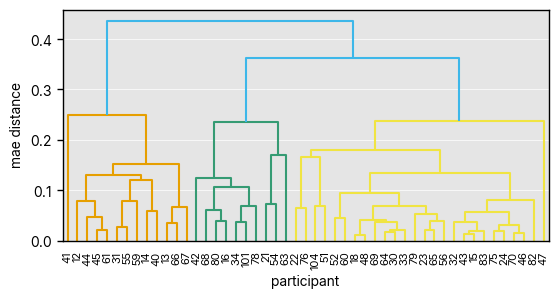

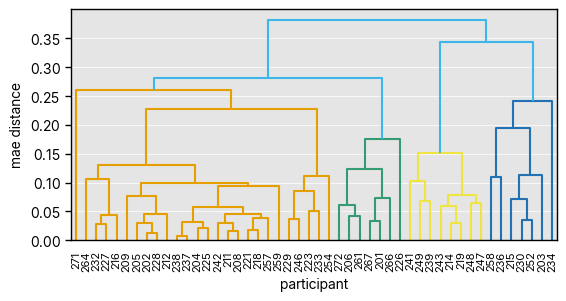

In [19]:
%matplotlib inline

from scipy.cluster.hierarchy import linkage, dendrogram
from statsmodels.multivariate.manova import MANOVA

m = 'mae'
model = 'clipped-shallow-PLRNN'

clustered_std = []
features = metrics[m].index.get_level_values('feature').unique()

with PaperStyle():

    for mrt in MRT:

        pid = metrics[m].loc[(mrt, model)].dropna().index.get_level_values('participant').unique()

        y = metrics[m].loc[(mrt, model)].dropna().unstack('participant').to_numpy().T
        Z = linkage(y, method='complete', metric='cosine', optimal_ordering=True)
        
        fig, ax = plt.subplots(figsize=(6.27, 3))
        dn = dendrogram(Z, ax=ax, labels=pid, leaf_rotation=90)
        ax.set(ylabel=f'{m} distance', xlabel='participant')

        cluster_index = pd.Series(dn['leaves_color_list'], index=dn['ivl'])
        for_manova = std.loc[mrt].unstack('feature')
        for_manova['cluster'] = cluster_index

        manova = MANOVA.from_formula(' + '.join(features) + ' ~ C(cluster)', data=for_manova)
        print(manova.mv_test())
        plt.savefig(f'../results/_paper/clustered_participants_mrt_{mrt}_{model}.png', dpi=300)

        clustered_std.append(for_manova)
    
    plt.show()
clustered_std = pd.concat(clustered_std, axis=0, keys=MRT, names=['MRT'])

Plot the different item predictabilities for clusters, MRT 2 only

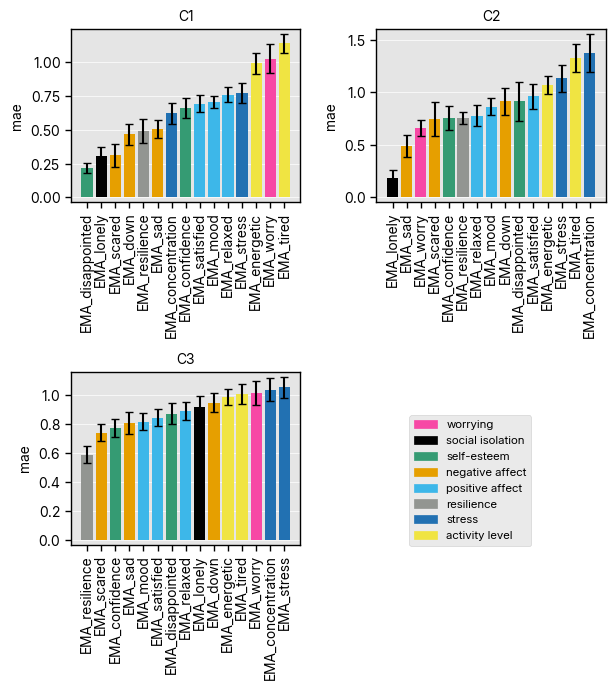

In [24]:
%matplotlib inline

import matplotlib.pyplot as plt
from plotting_styles import PaperStyle, colors
from plotting_utils import adjust_ylim

mrt = 2

features = metrics['mae'].index.get_level_values('feature').unique()
clustered_mae = metrics['mae'].loc[(mrt, model)].unstack('feature')
clustered_mae['cluster'] = clustered_std.loc[mrt, 'cluster']
clusters = sorted(clustered_mae['cluster'].unique())

with PaperStyle():

    fig, axes = plt.subplots((len(clusters)+1)//2, 2, figsize=(6.27, 7))
    axes = axes.flatten()

    mean_metric = clustered_mae.groupby('cluster').mean()
    sem_metric = clustered_mae.groupby('cluster').sem()
    for i, cluster in enumerate(mean_metric.index):
        order = mean_metric.loc[cluster].sort_values().index
        this_line = mean_metric.loc[cluster, order]
        this_errorbars = sem_metric.loc[cluster, order]
        axes[i].bar(range(len(features)), this_line, yerr=this_errorbars, capsize=3, color=colors.item_color_codes(order, version='construct'))
        adjust_ylim(axes[i], 0.03, 0.03)
        
        axes[i].set(ylabel=m, xticks=range(len(features)))
        axes[i].set_xticklabels(order, rotation=90)
        axes[i].set(title=cluster)
    plt.tight_layout()
    if len(clusters) % 2 == 1:
        axes[-1].remove()
    axes[-3].legend(*colors.construct_legend_handles_labels(*set(colors.item_cosntructs(features))),
                            bbox_to_anchor=(0.7, -1.2))
    plt.savefig(f'../results/_paper/individual_items_clusters_{model}_mrt_{mrt}.png', dpi=300)
    plt.show()

Std of Items "worry" and "concentration" for all the clusters

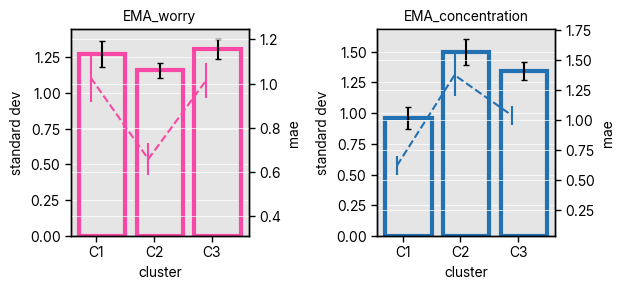

In [21]:
import numpy as np

items = ['EMA_worry', 'EMA_concentration']
# items = features

with PaperStyle():

    fig, axes = plt.subplots((len(items)+1)//2, 2, figsize=(6.27, len(items)*1.5))
    axes = axes.flatten()
    cluster_mean_std = clustered_std.loc[mrt].groupby('cluster').mean()
    cluster_sem_std = clustered_std.loc[mrt].groupby('cluster').sem()
    cluster_mean_mae = clustered_mae.groupby('cluster').mean()
    cluster_sem_mae = clustered_mae.groupby('cluster').sem()
    for i, item in enumerate(items):
        axes[i].bar(np.arange(len(clusters))+0.1, cluster_mean_std[item], yerr=cluster_sem_std[item], 
                    edgecolor=colors.item_color_codes(item), linewidth=3, facecolor='none')
        axes[i].set(xlabel='cluster', ylabel='standard dev', xticks=range(len(clusters)), xticklabels=clusters, title=item)
        adjust_ylim(axes[i], bottom=0)
        twinax = axes[i].twinx()
        twinax.errorbar(np.arange(len(clusters))-0.1, cluster_mean_mae[item], yerr=cluster_sem_mae[item], 
                        color=colors.item_color_codes(item), linestyle='--', capsize=0)
        twinax.set(ylabel='mae')
        adjust_ylim(twinax, top=0.2, bottom=0.5)
    plt.tight_layout()
    plt.savefig(f'../results/_paper/worry_concentration_std_clusters_{model}_mrt_{mrt}.png', dpi=300)
    plt.show()
